# 18.06 Problem Set 8 Solutions

## Problem 1 (5+5+5 points)

In this problem you will use **principal components analysis (PCA)** and the SVD to classify a large number of images.

The code below downloads a [collection of 136 images](https://math.mit.edu/~stevenj/amazon-teapots.zip) found by searching amazon.com for "teapot" in Fall 2022, shown in miniature here:

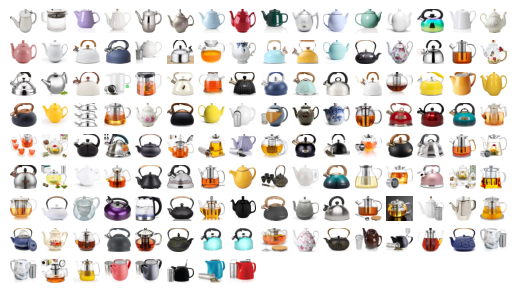

Each image is resized to a common size of $350 \times 380$, and then reshaped into a vector of $350\times380\times 3 = 399000$ numbers (the red, green, and blue intensities of each RGB color pixel), and stored in a matrix $X$ of "measurements" for 136 images:
$$
X = 136\times399000 \mbox{ matrix} = \mbox{(# images)} \times \mbox{(data per image)}
$$
Think of this as 136 points in a **399000-dimensional space**, i.e. each image is a point in $\mathbb{R}^{399000}$!!

PCA allows us to figure out which combinations of these 399000 variables explain most of the variations, and allows us to *project* from $\mathbb{R}^{399000}$ to a *much* lower-dimensional space in order to help us *classify* the data and identify *clusters* of similar images.   In this problem, you will perform the PCA clustering analysis yourself.

You will need to install some Julia packages to help extract the image data.  
```jl
import Pkg
Pkg.add("ZipFile")
Pkg.add("Images")
Pkg.add("FileIO")
```
(or type `] add ZipFile Images FileIO`).

You can then run the following code to download the data and reshape it into our $X$ matrix:

In [1]:
using ZipFile, Images, FileIO, Statistics, LinearAlgebra, PyPlot

# download the files as a zip archive:
imagezip = download("https://math.mit.edu/~stevenj/amazon-teapots.zip")

rows, cols = 350,380  # common size to resize all of the images to

# extract the images from the zip file, load them, resize them, and stick them into a big array Xdata
Xdata = Float64[]
r = ZipFile.Reader(imagezip)
for f in r.files
    # load image and rescale to rows x cols
    image = imresize(load(IOBuffer(read(f))), rows, cols)
    imagedata = Float64.(channelview(image))
    if length(imagedata) == rows*cols # grayscale
        imagedata = [imagedata; imagedata; imagedata] # convert to RGB
    end
    append!(Xdata, imagedata)
end

# remove duplicates and reshape into 136×399000 matrix X
Y = reshape(Xdata, :, length(r.files)) # reshape to (imagesize) x (numimages) matrix
X = reduce(hcat, unique(eachcol(Y)))' # remove duplicates and transpose
@show size(X)

# a useful function to reshape a length-399000 vector into a color image and plot it
function plotimg(imgdata, rows=rows, cols=cols)
    u = copy(imgdata)
    u .-= minimum(u)
    u ./= maximum(u)
    imshow(permutedims(reshape(u, 3, rows, cols), (2,3,1)))
    axis("off")
end

size(X) = (136, 399000)


plotimg (generic function with 3 methods)

Once you have the data:

**(a)** As in class, **subtract the mean of each column** of $X$ from that column to form a new matrix $A$.   (That is, subtract the mean of each pixel/color over all the images.)   `A = ....`

Given `A`, compute `U, σ, V = svd(A)` and `plot(σ, "b.-")` (be sure to add a title and axes labels too) to see the singular values $\sigma$.   As usual, some singular values should be much bigger than others.

**(b)** Compute the coefficients of the *orthogonal projection* of each mean-subtracted image (each row of `A`) onto the two dominant singular vectors \_\_\_\_\_ and \_\_\_\_\_, to obtain 136 coefficients $c_1$ and 136 coefficients $c_2$, respectively.

Plot these coefficients, along with a numeric label for the index each image, with the following code (be sure to add axes labels and a title).  You have now reduced your 399000-dimensional data into **points in 2 dimensions**.
```jl
figure(figsize=(20,15))
plot(c1, c2, "r.")
text.(c1, c2, string.(1:length(c1)), fontsize=11);
```

**(c)** In the 2d plot of (b), clusters of nearby points should represent similar teapots in some way.   Pick **three clusters** of **3 nearby points each**,  with different clusters **far** from one another in the plot from (b).   For each cluster, plot the 3 corresponding images (rows of `X`) with `plotimg`.  For example, here is how you would plot (side-by-side) the 27th, 33rd, and 49th images:
```jl
subplot(1,3,1)
plotimg(X[27,:])
subplot(1,3,2)
plotimg(X[33,:])
subplot(1,3,3)
plotimg(X[49,:])
```
You should find that the nearby (clustered) teapots are much more similar to one another (in some way) than they are to the clusters far away.

### Solution

We start by running the code above from the problem to set up the data.  This gives us the raw data matrix `X`.

In [2]:
X

136×399000 adjoint(::Matrix{Float64}) with eltype Float64:
 0.996078  0.996078  0.996078  0.996078  …  1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 0.996078  0.996078  0.996078  0.996078     1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0       …  1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0       …  1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 1.0       1.0       1.0       1.0          1.0       1.0       1.0
 ⋮                                       ⋱               

**(a)** There are several ways to subtract the mean from each column of $X$.

The most 18.06-style way is to use the fact that this is *exactly* a projection operation, as we [showed in class](https://nbviewer.org/github/mitmath/1806/blob/master/notes/Statistics-and-PCA.ipynb):

$$
\boxed{A = \left( I - \frac{oo^T}{o^T o} \right) X = X - \frac{o(o^T X)}{o^T o}}
$$

where $o = [1,1,\ldots,1]$ is the column vector of 136 1's, formed in Julia by `ones(136)`.  (For efficiency's sake, it is nicer to compute $o(o^T X)$ than $(oo^T)X$, since matrix–vector products are much cheaper than matrix–matrix products, but this isn't necessary).

In Julia, this is:

In [4]:
o = ones(size(X,1)) # column vector of 136 1's

A = X - o * (o'X) / (o'o);  # compute X - ooᵀX/oᵀo

Alternatively, we could use the [`mean` function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) provided by Julia's `Statistics` library to take the mean of each column, and then subtract this from each column with [broadcasting](https://docs.julialang.org/en/v1/manual/arrays/#Broadcasting).

`mean(X)` is not what we want!  That would return a *single number*, the mean of *all* the entries in `X`.  Instead, we want `mean(X, dims=1)`, the mean taken along the first (row) "direction", returning a **row vector** of the means of each column:

In [5]:
mean(X, dims=1) # the mean of each column of X

1×399000 Matrix{Float64}:
 0.993916  0.993858  0.994089  0.993916  …  0.994867  0.994493  0.993743

We could then subtract this from each column with `X .- mean(X, dims=1)`, which returns the same result (up to roundoff errors) as our projection above:

In [6]:
A ≈ X .- mean(X, dims=1)

true

(Of course, there are other more laborious ways to compute $A$.  You could write your own loop, you could perform a [`map`](https://docs.julialang.org/en/v1/base/collections/#Base.map) operation on [`eachcol(X)`](https://docs.julialang.org/en/v1/base/arrays/#Base.eachcol), etcetera.   But in 18.06, I would recommend trying to formule things as linear-algebra operations if you can!)

In [15]:
A ≈ reduce(hcat, map(col -> col .- mean(col), eachcol(X)))  # yet another solution, even more convoluted

true

Now, we compute SVD of $A$ and build the plot.

We see that the few singular values are much bigger than the others, as we often do!  On the other hand, the contrast between $\sigma_1$ and the smaller singular values is only about a factor of 10, which tells us that these images are not really low-dimensional — a lot of things are going on.  Still, hopefully the largest singular values will tell us something useful about the images.

In [16]:
U, σ, V = svd(A);

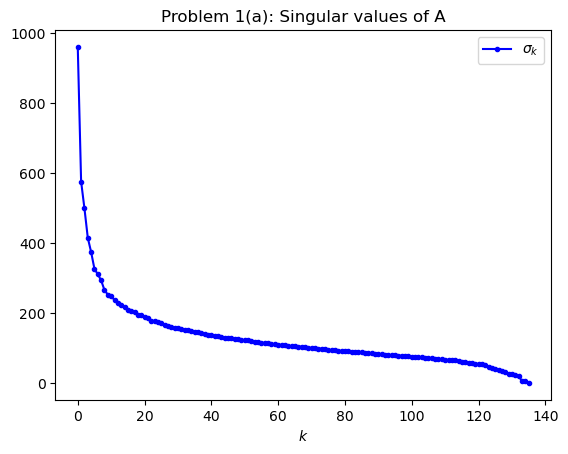

In [17]:
plot(σ, "b.-")

title("Problem 1(a): Singular values of A");
xlabel(L"k");
legend([L"\sigma_k"]);

**(b)** Here, we want to project onto $\boxed{v_1, v_2}$, the first two *right* singular vectors (v's) of $A$.

Remember, the u's (*left* singular vectors) are a basis for the *columns* (column space) of $A$, and the v's are a basis for the *rows* (row space) of $A$.   Here, each row is an image, so a basis for the images will be the **v's**, not the u's.   (The u's have the wrong shape!  They have only 136 components each!)

Also, [we saw in class](https://nbviewer.org/github/mitmath/1806/blob/master/notes/Statistics-and-PCA.ipynb) that, for a matrix organized like this (rows = different samples, columns = different variables), the v's give us *uncorrelated combinations of variables*, and the largest σ's correspond to the *dominant uncorrelated combinations of variables*.  This is the whole point of PCA: the v's give us the right way to look at the input measurements.

(Note that some authors transpose their data — they use a matrix X whose *rows* are the variables and whose *columns* are the samples, in which case the roles of rows/columns and u's/v's are swapped.)

Morever, remember the distinction between the *projection* and the *coefficient* of the projection.  We want to write each image in the $v$ basis as:
$$
\mbox{image} = \underbrace{v_1 \mbox{(coefficient 1)}}_{v_1\mbox{ projection}} + \underbrace{v_2 \mbox{(coefficient 2)}}_{v_2\mbox{ projection}} + \cdots
$$
and what we want to know here is *not* the projection but rather the *coefficients* of the projection: the coefficient $c_1$ of each image in the $v_1$ direction and the coefficient $c_2$ of each image in the $v_2$ direction.  These are the "coordinates" of the images in the $(v_1, v_2)$ basis suggested to us by PCA.

Hence, we want
$$
\boxed{c_1 = A v_1, \; c_2 = A v_2}
$$
which are the *dot products* of $v_1$ and $v_2$ (respectively) with *each row of A* (each mean-subtracted image).  In Julia, this is simply: 

In [18]:
# the dominant two right-singular vectors are just the 1st two columns of V:
v1 = V[:, 1]
v2 = V[:, 2]

# now we want the dot product of each image with these directions:
c1 = A*v1
c2 = A*v2;

The general idea is that the numbers in $c_1$ $c_2$ give an approximation for the whole information in $A$, drasticly compressing the amount of data. Now we plot this compressed data on a plane with the goal to notice some patterns in our data.

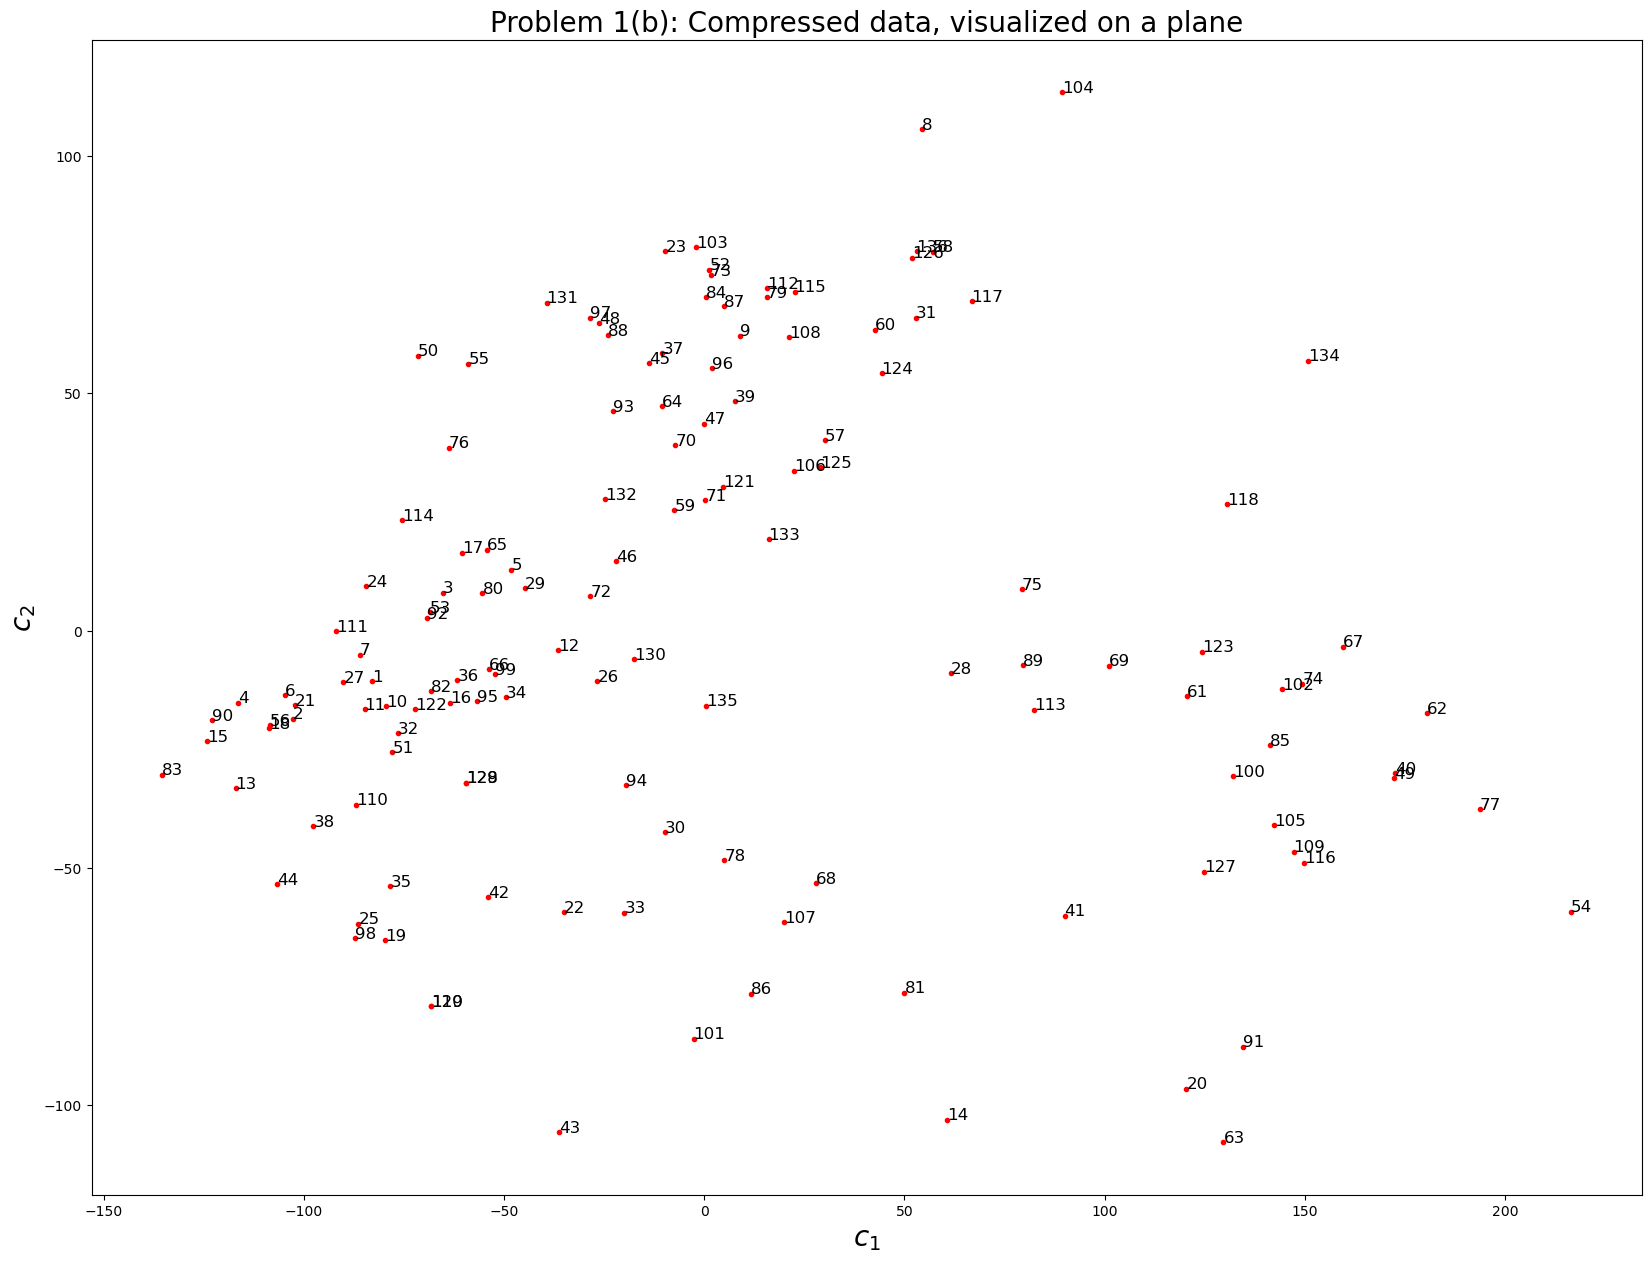

In [19]:
figure(figsize=(20,15))
plot(c1, c2, "r.")
text.(c1, c2, string.(1:length(c1)), fontsize=12);

title("Problem 1(b): Compressed data, visualized on a plane", fontsize=20);
xlabel(L"$c_1$", fontsize=20);
ylabel(L"$c_2$", fontsize=20);

**(c)** There are many possible choices of clusters. For this solution we pick a small cluster on the right (points 105, 109, 116), a cluster on the top around the point $(0, 75)$ (points 73, 103, 84) and a cluster on the left around the point $(-70, -15)$ (points 122, 82, 10). Below are the triples of pictures for these clusters.

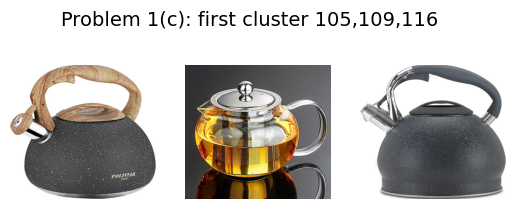

PyObject Text(0.5, 0.75, 'Problem 1(c): first cluster 105,109,116')

In [26]:
subplot(1,3,1)
plotimg(X[105,:])
subplot(1,3,2)
plotimg(X[109,:])
subplot(1,3,3)
plotimg(X[116,:])
gcf().suptitle("Problem 1(c): first cluster 105,109,116", fontsize=14, y=0.75)

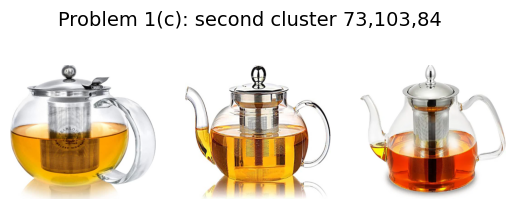

PyObject Text(0.5, 0.75, 'Problem 1(c): second cluster 73,103,84')

In [27]:
subplot(1,3,1)
plotimg(X[73,:])
subplot(1,3,2)
plotimg(X[103,:])
subplot(1,3,3)
plotimg(X[84,:])
gcf().suptitle("Problem 1(c): second cluster 73,103,84", fontsize=14, y=0.75)

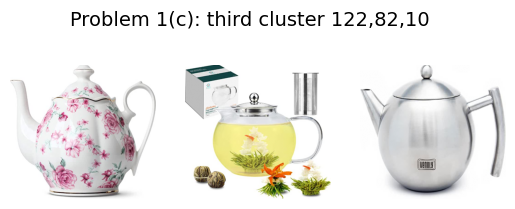

PyObject Text(0.5, 0.75, 'Problem 1(c): third cluster 122,82,10')

In [28]:
subplot(1,3,1)
plotimg(X[122,:])
subplot(1,3,2)
plotimg(X[82,:])
subplot(1,3,3)
plotimg(X[10,:])
gcf().suptitle("Problem 1(c): third cluster 122,82,10", fontsize=14, y=0.75)

We can observe that the pictures are indeed similar within clusters and have distinctive features separating them form the other clusters. For example, all pictures in the second cluster feature significant amount of amber color, with a roundish shape of the kettle.

We can also see some imperfect results: the second picture in the first cluster is there because of the gray background, not because of the teapot itself.  (Image classification is hard, and one has to be espeically careful of effects due to simple changes in lighting or subject framing!)

## Problem 2 (2+2+2+2 points)

(from Strang pset 5.1)

If a $4\times 4$ matrix has $\det A = \frac{1}{2}$, find $\det(2A)$, $\det(-A)$, $\det(A^2)$, and $\det(A^{-1})$.

### Solution

Recall the following properties of determinants: 

* For an $n\times n$ matrix $A$ and an arbitrary scalar $\lambda$ we have  $\det(\lambda A) = \lambda^n \det A $. More precisely: to get from $A$ to $\lambda A$ we need to multiply each row of $A$ by $\lambda$. Each such multiplication multiplies the determinant by $\lambda$, so $n$ rows will result in $\lambda^n$ factor for the determinant.

* $\det (AB)=\det(A) \det(B)$. In particular, $\det(A)\det(A^{-1})=\det(AA^{-1})=\det(I)=1$, so $\det(A^{-1})=\det(A)^{-1}$.

Now we can solve the problem. Recall that $A$ has size $4\times 4$ and $\det(A)=\frac12$.

$$
\boxed{\det(2A)=2^4\det(A)=8;}\qquad \boxed{\det(-A)=(-1)^4\det(A)=\frac12;}\qquad\boxed{\det(A^2)=\det(A)^2=\frac14;}\qquad\boxed{\det(A^{-1})=\det(A)^{-1}=2.}
$$


## Problem 3 (4+4+4+4 points)

(from Strang pset 5.1)

**True** or **false** (give a *reason* if true or a $2\times 2$ *counter-example* if false), using the properties of determinants.  $A$ and $B$ are square matrices.

**(a)** If $A$ is not invertible then $AB$ is not invertible.

**(b)** The determinant of $A$ is always the product of its pivots.

**(c)** $\det(A-B)$ always equals $\det(A) - \det(B)$.

**(d)** $AB$ and $BA$ must have the same determinant.

### Solution

**(a)** **True.** Recall that a matrix $M$ is invertible if and only if $\det(M)=0$. If $A$ is not invertible, then $\det(A)=0$, hence $\det(AB)=\det(A)\det(B)=0$ and so $AB$ is also not invertible.

**(b)** **False.** 

The term "pivots of A" can sometimes be used a bit loosely, but whichever interpretation you use gives the same answer.  Suppose we do Gaussian elimination on $A$ and get an upper-triangular matrix $U$.  Then

* If one interprets the "pivots of A" as simply the diagonal elements of $U$, then their product is *almost* but not quite the determinant: it has the right magnitude, but the sign may be flipped if there was an **odd number of row swaps**.  For example, with $A=\begin{pmatrix}0 & 1\\ 1& 0\end{pmatrix}$ you are *forced* to do a row swap during elimination, and then just obtain $U=I$ with $\det U = 1$.  But $\det A = -1$ here.

* To be more precise, however, we usually don't count a diagonal entry of $U$ as a "pivot" if it is zero: the "pivots" are the first *nonzero* entry in each row of $U$.   With this definition, the "product of the pivots" is always nonzero, but the determinant is zero if the matrix is singular (if there aren't enough pivots).  For example, the matrix $A=\begin{pmatrix}0 & 1\\ 0& 0\end{pmatrix}$ has only one pivot equal to $1$, but $\det(A)=0$.

Of course, by choosing to do different permutations of the rows of $A$, we could get many different $U$ matrices from elimination, and hence many different possible values for the individual pivots and/or diagonal entries.  But the amazing fact is that, even though the matrix $U$ and the values of the diagonal entries of $U$ may change depending on how one permutes the rows, the *product* of the diagonal entries of $U$ will always equal $\pm \det A$, with the sign determined by the number of row swaps!

**(c)** **False.** For example, take $A=\begin{pmatrix}1 & 0\\ 0& 1\end{pmatrix}$ and $B=\begin{pmatrix}0 & 0\\ 0& 1\end{pmatrix}$. Then $A-B=\begin{pmatrix}1 & 0\\ 0& 0\end{pmatrix}$ and $\det(A-B)=0$, but $\det(A)-\det(B)=1-0=1$.

**(d)** **True.** $\det(AB)=\det(A)\det(B)=\det(B)\det(A)=\det(BA)$.

## Problem 4 (5+5+5 points)

**(a)** If $Q$ is a unitary matrix, from the properties of determinants explain why $\det Q$ must be \_\_\_\_\_\_\_\_ or \_\_\_\_\_\_\_\_.

**(b)** If $P$ is a $3 \times 3$ projection matrix onto a 2d subspace, then explain why its determinant must be \_\_\_\_\_\_\_\_.

**(c)** If $A$ is a $5 \times 5$ matrix that is anti-symmetric ($A^T = -A$), then explain why its determinant must be \_\_\_\_\_\_\_\_.   Try it for a few random matrices: if `B = randn(5,5); A = B - B'` produces an anti-symmetric `A`, and check `det(A)`.  (Be sure to load `using LinearAlgebra` first to get the `det` function.)

### Solution

**(a)** $\det Q$ must be $\boxed{1}$ or $\boxed{-1}$. Recall that a unitary matrix $Q$ is a matrix such that $Q^T=Q^{-1}$. Taking determinants of both sides and using properties of determinants, we have 
$$
\det(Q)=\det(Q^T)=\det(Q^{-1})=\frac{1}{\det(Q)}.
$$
Hence $\det(Q)^2=1$ which implies $\det(Q)=\pm1$.

**(b)** The determinant of $P$ must be $\boxed{0}$. Note that the matrix $P$ is not invertible: it projects onto a 2-dimensional space, consequently $C(P)$ has dimension $2$ and $P$ is not of full-column rank. Since $P$ is not invertible, $\det P=0$.

**(c)** $\det A$ must be $\boxed{0}$. Recall that for an $5\times 5$ matrix $A$ we have $\det(-A)=(-1)^5\det(A)=-\det(A)$. So, if $A^T=-A$, we have
$$
\det(A)=\det(A^T)=\det(-A)=-\det(A),
$$
which is only possible if $\det(A)=0=-\det(A)$. The code to try this for a few random matrices is shown below:

In [29]:
using LinearAlgebra;
for i = 1:10
    B=randn(5,5)
    A=B-B'
    @show det(A)
end

det(A) = 1.21069476712944e-16
det(A) = -3.3264036182300682e-15
det(A) = -1.5275124982741926e-15
det(A) = -5.311646714207018e-18
det(A) = 1.0363047720795372e-16
det(A) = 0.0
det(A) = 3.4289498760725383e-15
det(A) = -4.040333952221032e-15
det(A) = -2.106038509542208e-14
det(A) = 2.0857732790276202e-16


As predicted, the determinant is *essentially* zero — up to roundoff errors.  (In principle, all of the terms in the determinant should cancel *exactly*, but due to the finite precision of computer arithmetic there is usually a tiny leftover.)

## Problem 5 (10 points)

Find the determinant of the $6 \times 6$ matrix:
$$
A = \begin{pmatrix}
1 & -1 & 0 & 0 & 0 & 0\\
-1 & 2 & -1 & 0 & 0 & 0\\
0 & -1 & 2 & -1 & 0 & 0\\
0 & 0 & -1 & 2 & -1 & 0\\
0 & 0 & 0 & -1 & 2 & -1\\
0 & 0 & 0 & 0 & -1 & 2\\
\end{pmatrix} \, .
$$

### Solution

To find the determinant of $A$ we perform Gausssian elimination. Recall that the operations with rows done during the elimination do not change the determinant (except for swaps, which change the sign), so $\det A$ will be equal to the determinant of the result of the elimination. 

The elimination is provided below. It turns out to be fairly simple: at each step we just add one row to a row below, starting from the top row.

$$
\underbrace{
\begin{pmatrix}
1&-1&0&0&0&0\\
-1&2&-1&0&0&0\\
0&-1&2&-1&0&0\\
0&0&-1&2&-1&0\\
0&0&0&-1&2&-1\\
0&0&0&0&-1&2
\end{pmatrix}}_A \to
\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&-1&2&-1&0&0\\
0&0&-1&2&-1&0\\
0&0&0&-1&2&-1\\
0&0&0&0&-1&2
\end{pmatrix}\to
\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&0&1&-1&0&0\\
0&0&-1&2&-1&0\\
0&0&0&-1&2&-1\\
0&0&0&0&-1&2
\end{pmatrix}\to
\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&0&1&-1&0&0\\
0&0&0&1&-1&0\\
0&0&0&-1&2&-1\\
0&0&0&0&-1&2
\end{pmatrix}\to
\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&0&1&-1&0&0\\
0&0&0&1&-1&0\\
0&0&0&0&1&-1\\
0&0&0&0&-1&2
\end{pmatrix}\to
\underbrace{\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&0&1&-1&0&0\\
0&0&0&1&-1&0\\
0&0&0&0&1&-1\\
0&0&0&0&0&1
\end{pmatrix}}_U
$$

So, we get 
$$
\det A=\det U = \det\begin{pmatrix}
1&-1&0&0&0&0\\
0&1&-1&0&0&0\\
0&0&1&-1&0&0\\
0&0&0&1&-1&0\\
0&0&0&0&1&-1\\
0&0&0&0&0&1
\end{pmatrix}=\boxed{1}.
$$
For the last equality we have rememebered that the determinant of an upper-triangular matrix is equal to the product of the diagonal entries.  (And no row swaps were required, so $\det A = \det U$.)